This notebook will build up models from the baseline given here: https://github.com/asapdiscovery/asap-polaris-challenge-baselines/blob/main/ADMET/admet_baselines.ipynb

In [ ]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels as sm
import datamol as dm
import yellowbrick

The baseline is all done on the untransformed data, since i'm working on the log transformed, the models won't be comparable. 

In [107]:
train = pd.read_csv('imputed/train_admet_log_pmm.csv')
val = pd.read_csv('imputed/val_admet_log_pmm.csv')

train['split'] = 'train'
val['split'] = 'val'
data = pd.concat([train, val], axis=0)
data.rename(columns={'.imp': 'imp'}, inplace=True)

x_col = 'CXSMILES'
y_cols = ['LogMLM', 'LogHLM', "LogKSOL", "LogD", "LogMDR1.MDCKII"]

# data['cLogP'] = data["CXSMILES"].apply(lambda x: dm.descriptors.clogp(dm.to_mol(x)))


In [109]:
def _preprocess(i, row):

    dm.disable_rdkit_log()

    mol = dm.to_mol(row['CXSMILES'], ordered=True)
    mol = dm.fix_mol(mol)
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
    mol = dm.standardize_mol(
        mol, disconnect_metals=False, normalize=True, reionize=True, uncharge=False, stereo=True
    )
    feats = dm.descriptors.compute_many_descriptors(mol)
    feats['Molecule.Name'] = row['Molecule.Name']
    return feats
    
df = data.loc[data.imp == 0, :]

feats = dm.parallelized(_preprocess, df.iterrows(),arg_type="args", progress=True, total=len(df))
feats = pd.DataFrame(feats)
feats.head()

100%|██████████| 434/434 [00:05<00:00, 82.16it/s] 


,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,n_radical_electrons,tpsa,...,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings,Molecule.Name
0,311.103669,0.428571,6,3,2,7,21,3,0,84.66,...,0,1,1,1,0,1,0,1,1,ASAP-0032437
1,483.052459,0.380952,4,3,4,8,29,7,0,53.16,...,1,1,2,2,0,2,1,0,1,ASAP-0031915
2,449.066279,0.263158,6,4,4,9,28,6,0,81.84,...,0,1,1,2,1,3,0,0,0,ASAP-0031884
3,286.131742,0.375000,5,2,3,5,21,3,0,76.54,...,0,1,1,1,1,2,0,1,1,ASAP-0031848
4,261.147727,0.500000,5,2,2,5,19,3,0,76.29,...,0,1,1,0,1,1,0,1,1,ASAP-0031813


In [110]:
data = data.merge(feats, on=['Molecule.Name'], how='left')
data.shape

(43834, 32)

In [118]:
??dm.descriptors.compute_many_descriptors

Signature:
dm.descriptors.compute_many_descriptors(
    mol: rdkit.Chem.rdchem.Mol,
    properties_fn: Optional[Dict[str, Union[Callable, str]]] = None,
    add_properties: bool = True,
) -> dict
Source:   
def compute_many_descriptors(
    mol: Mol,
    properties_fn: Optional[Dict[str, Union[Callable, str]]] = None,
    add_properties: bool = True,
) -> dict:
    """Compute a list of opiniated molecular properties.

    Args:
        mol: A molecule.
        properties_fn: A list of functions that compute properties. If None,
            a default list of properties is used. If the function is a string,
            `dm.descriptors.any_descriptor()` is used to retrieve the descriptor
            function.
        add_properties: Whether to add the computed properties to the default list.

    Returns:
        Computed properties as a dict.
    """

    if properties_fn is None:
        properties_fn = _DEFAULT_PROPERTIES_FN
    elif add_properties:
        [properties_fn.setdefault(k,

In [121]:
predictors = list(dm.descriptors.compute._DEFAULT_PROPERTIES_FN.keys())

# Linear models with and without imputation

## Single predictor: cLogP
We'll use the median of the predictions against the unimputed validation dataset. 

In [111]:
# Mixin classes should always be on the left-hand side for a correct MRO
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn import linear_model


class ImputedLinearModel(RegressorMixin, BaseEstimator):
    def __init__(self, fit_intercept=True, copy_X=True, n_jobs=None, positive=False):
        self.fit_intercept = fit_intercept
        self.copy_X = copy_X
        self.n_jobs = n_jobs
        self.positive = positive
        self.models = {}

    def fit(self, X, y, imp_idx, use_imp = True):
        self.is_fitted_ = True
        ## All the imputation 
        m = np.unique(imp_idx).shape[0]
            # imp_idx = 0 is the unimputed data
        if use_imp: 
            for i in range(1, m): 
                mod = linear_model.LinearRegression()
                use_rows = imp_idx == i 
                self.models[i] = mod.fit(X[use_rows, :], y[use_rows])
        else: 
            mod = linear_model.LinearRegression()
            use_rows = (imp_idx == 0) & (~np.isnan(y))

            self.models[0] = mod.fit(X[use_rows, :], y[use_rows])

        return self
    def predict(self, X):
        preds = []
        for i, mod in self.models.items():
            preds.append(mod.predict(X).reshape(-1, 1))
        return np.mean(np.concatenate(preds, axis=1), axis=1)

    


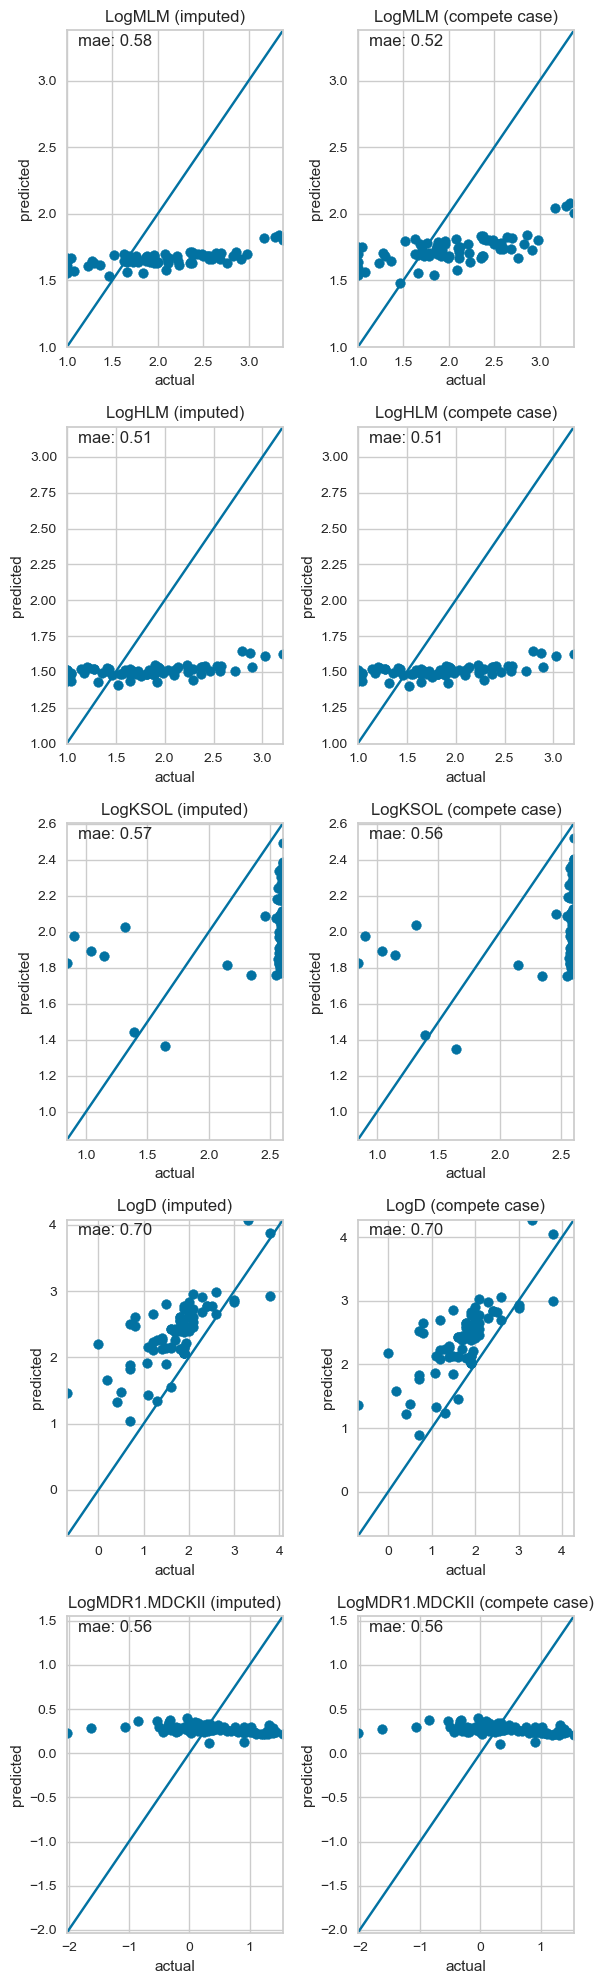

In [124]:
def fit_linear_model(data, predictor_cols, y_cols, model_name):
        fig, axes = plt.subplots(len(y_cols), 2, figsize=(6, len(y_cols)*4))
        models = {}
        for i, target in enumerate(y_cols): 
                for j, use_imp in enumerate([True, False]):

                        model = ImputedLinearModel()
                        model.fit(data.loc[data.split=='train', predictor_cols].values, 
                                data.loc[data.split=='train', target].values, 
                                imp_idx=data.loc[data.split=='train', 'imp'].values, 
                                use_imp=use_imp)
                        
                        models[(target, use_imp)] = model

                        val_ix = (data.split=='val') & (data.imp == 0) & (~data[target].isna())

                        y_hat = model.predict(data.loc[ val_ix, predictor_cols].values).flatten()
                        y = data.loc[val_ix, target].values
                        y_min, y_max = np.concatenate((y, y_hat)).min(), np.concatenate((y, y_hat)).max() 
                        
                        axes[i, j].scatter(y, y_hat)
                        axes[i, j].set_xlim((y_min, y_max))
                        axes[i, j].set_ylim((y_min, y_max))
                        axes[i, j].plot([y_min, y_max], [y_min, y_max])
                        axes[i, j].set_xlabel(f'actual')
                        axes[i, j].set_ylabel(f'predicted')
                        axes[i, j].set_title(f"{target} ({'imputed' if use_imp else 'compete case'})")
                        axes[i, j].annotate(text=f"mae: {sk.metrics.mean_absolute_error(y, y_hat):4.2f}", xy=(0.05, 0.95), xycoords='axes fraction')
                        
        plt.tight_layout()
        plt.savefig(f'{model_name}.png', bbox_inches='tight')


fit_linear_model(data, predictor_cols=['clogp'], y_cols=y_cols, model_name='linear_model_0')

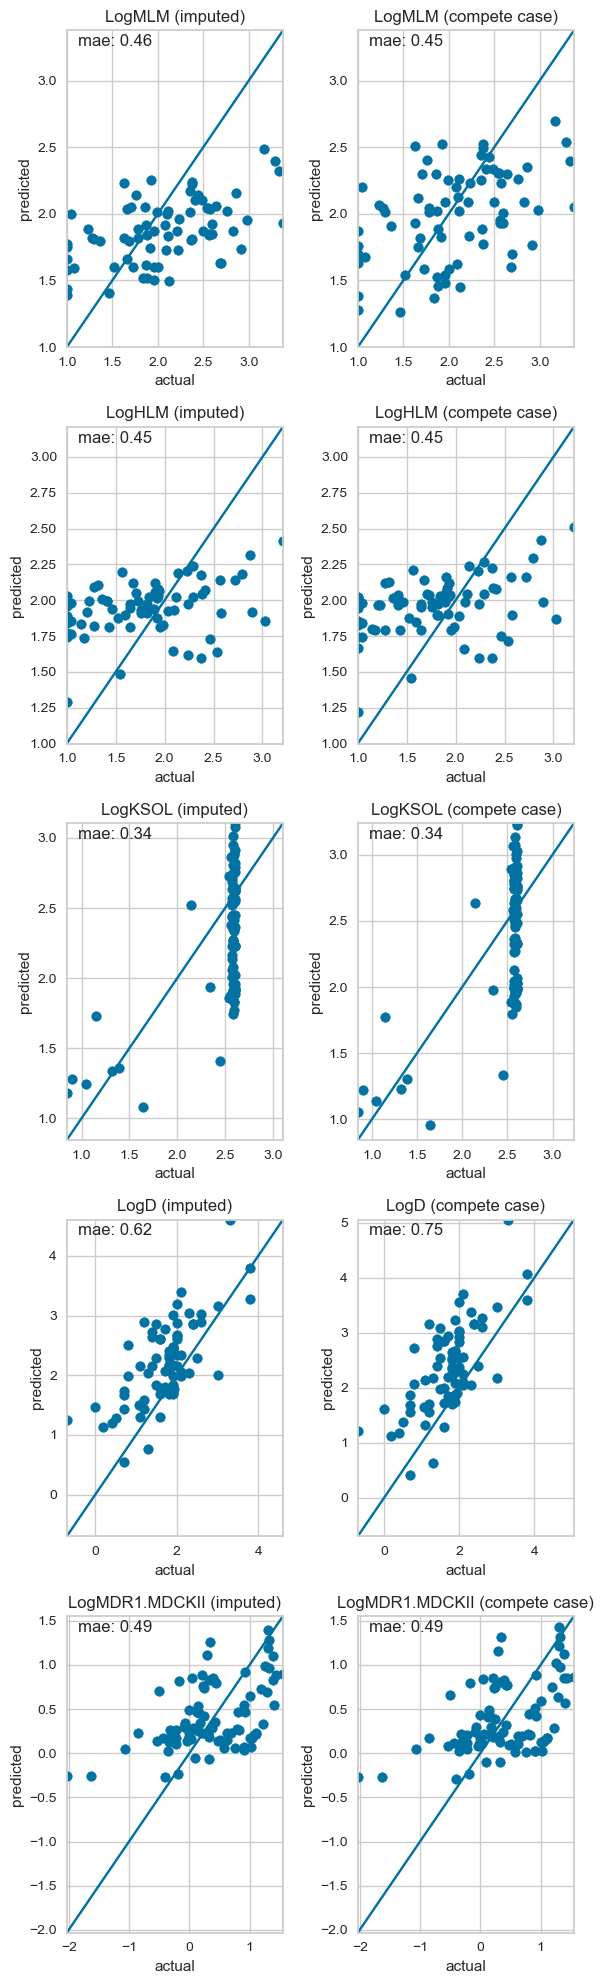

In [125]:

fit_linear_model(data, predictor_cols=predictors, y_cols=y_cols, model_name='linear_model_1')


(0.0035888405089897395,
 1.2192342485463192,
 -0.29349904765681345,
 0.6416134187920931)

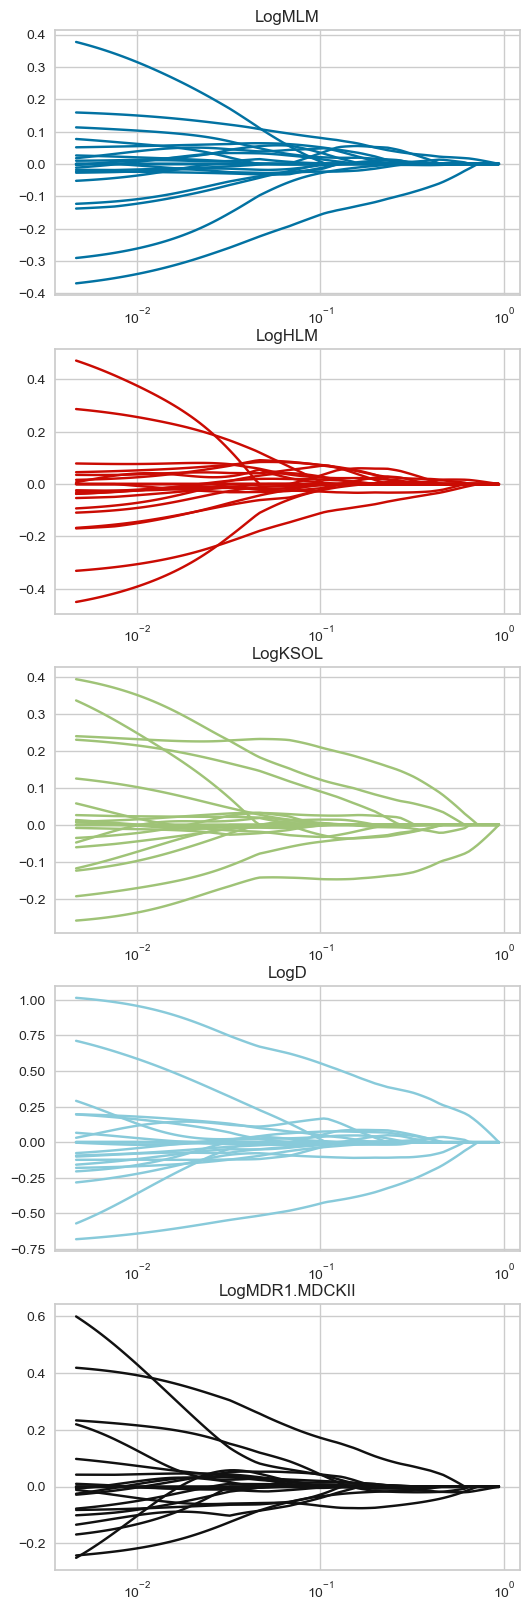

In [151]:
# mtencv = linear_model.MultiTaskElasticNetCV(
#     l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
#     n_alphas=100, 
#     cv=5,
# )
from sklearn.linear_model import enet_path
from itertools import cycle


scaler = sk.preprocessing.StandardScaler()
eps = 5e-3


X_train = data.loc[(data.imp==1) & (data.split=='train'), predictors].values
X_train_scaled = scaler.fit_transform(X_train)
y_train = data.loc[(data.imp==1) & (data.split=='train'), y_cols].values

X_val =data.loc[(data.imp==1) & (data.split=='val'), predictors].values 
X_val_scaled = scaler.transform(X_val)

alphas_enet, coefs_enet, _ = enet_path(X_train_scaled, y_train, eps=eps, l1_ratio=0.8)
# alphas_positive_enet, coefs_positive_enet, _ = enet_path(
#     X_train_scaled, y_train, eps=eps, l1_ratio=0.8, positive=True
# )



colors = cycle(["b", "r", "g", "c", "k"])
fig, axes = plt.subplots(len(y_cols), figsize=(6, 20))

for i, (coef_e, c) in enumerate(zip(coefs_enet, colors)):
    # print(coef_e.shape)
    # for i, y_col in enumerate(y_cols):
    for var_coef in coef_e:
        l1 = axes[i].semilogx(alphas_enet, var_coef, c=c)
        axes[i].set_title(y_cols[i])
        # axes[i].legend(l1[-1])

# plt.xlabel("alpha")
# plt.ylabel("coefficients")
# plt.title("Elastic-Net and positive Elastic-Net")
# plt.legend()
# # plt.legend((l1[-1], l2[-1]), ("Elastic-Net", "positive Elastic-Net"), loc="lower right")
plt.axis("tight")
# mtencv.fit(, data.loc[data.imp==1, y_cols].values)

In [139]:
coefs_enet.shape

(5, 22, 100)

In [141]:
alphas_enet.shape

(100,)